<a href="https://colab.research.google.com/github/gowrisankar393/vaylen-transitlk/blob/Multi-Sensor-Fusion-Crash-Detection/TransitLK_MSFCD_CVP_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Setup and Load Data**

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")

#mount drive
from google.colab import drive
drive.mount('/content/drive')

#dataset path
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/TransitLK_MSFCD_CVM.v1i.folder'

print(f"\nDataset path: {BASE_PATH}")

TensorFlow Version: 2.19.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Dataset path: /content/drive/MyDrive/Colab Notebooks/TransitLK_MSFCD_CVM.v1i.folder


##**Exploratory Data Analysis**

Exploratory Data Analysis

Dataset structure found:
  train: Crash=372, Normal=107, Total=479
  test: Crash=53, Normal=16, Total=69
  valid: Crash=107, Normal=30, Total=137

Dataset loaded: 685 images
   split  label                                           filename
0  train  crash  frame_0304_jpg.rf.e927a51cf337c5865482500ec768...
1  train  crash  frame_0657_jpg.rf.359712541d7a62a96cefd93b32f7...
2  train  crash  frame_0857_jpg.rf.5375b252c55f729e0b18b4d525a8...
3  train  crash  frame_0807_jpg.rf.0c66083928632501b428f1573880...
4  train  crash  frame_0585_jpg.rf.1695995818d0ff6815f4d35ea091...

1. Class Distribution (Crash vs Normal):
label
crash     532
normal    153
Name: count, dtype: int64

Crash rate: 77.66%


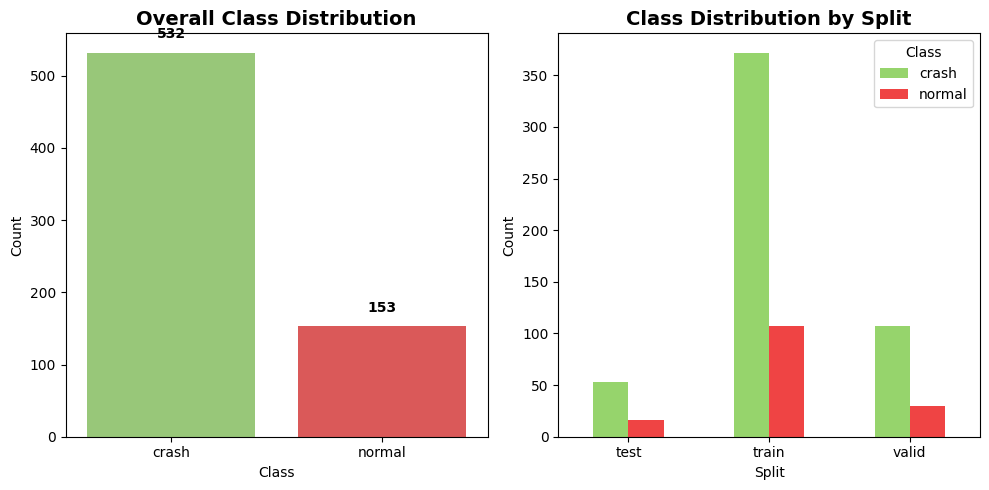


2. Sample Images:


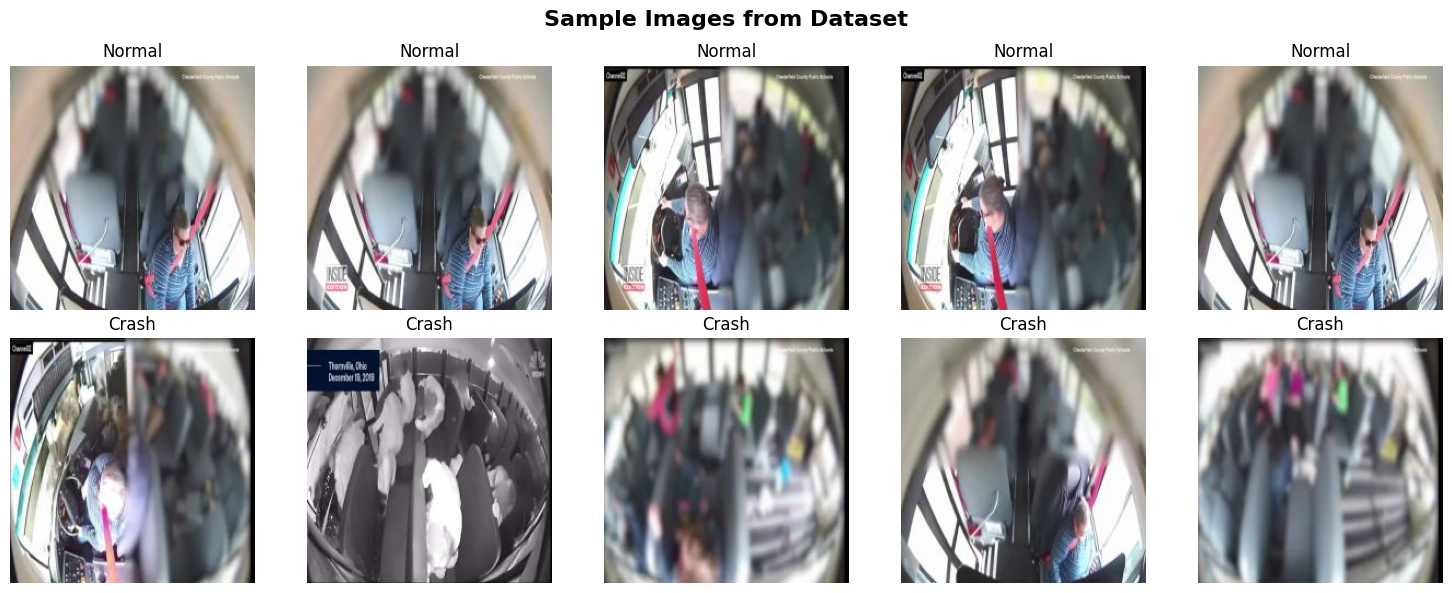

In [3]:
print("Exploratory Data Analysis\n")

#check if path exists and list structure
import os
if os.path.exists(BASE_PATH):
    print("Dataset structure found:")
    for split in ['train', 'test', 'valid']:
        split_path = os.path.join(BASE_PATH, split)
        if os.path.exists(split_path):
            crash_dir = os.path.join(split_path, 'crash')
            normal_dir = os.path.join(split_path, 'normal')
            crash_count = len([f for f in os.listdir(crash_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(crash_dir) else 0
            normal_count = len([f for f in os.listdir(normal_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(normal_dir) else 0
            print(f"  {split}: Crash={crash_count}, Normal={normal_count}, Total={crash_count + normal_count}")
else:
    print("Path not found! Please check your dataset location.")

#create dataframe for analysis
data = []
for split in ['train', 'test', 'valid']:
    for label in ['crash', 'normal']:
        folder = os.path.join(BASE_PATH, split, label)
        if os.path.exists(folder):
            files = [f for f in os.listdir(folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
            for f in files:
                data.append({'split': split, 'label': label, 'filename': f})

df = pd.DataFrame(data)
print(f"\nDataset loaded: {len(df)} images")
print(df.head())

#class distribution analysis
print("\n1. Class Distribution (Crash vs Normal):")
class_counts = df['label'].value_counts()
print(class_counts)
print(f"\nCrash rate: {class_counts.get('crash', 0)/len(df):.2%}")

#visualize class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['#96d46c','#ef4444'])
plt.title('Overall Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 20, str(v), ha='center', fontweight='bold')

#distribution by split
plt.subplot(1, 2, 2)
split_counts = df.groupby(['split', 'label']).size().unstack(fill_value=0)
split_counts.plot(kind='bar', ax=plt.gca(), color=['#96d46c', '#ef4444'])
plt.title('Class Distribution by Split', fontsize=14, fontweight='bold')
plt.xlabel('Split')
plt.ylabel('Count')
plt.legend(title='Class')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

#show sample images
print("\n2. Sample Images:")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')

for idx, label in enumerate(['normal', 'crash']):
    label_df = df[df['label'] == label]
    if len(label_df) > 0:
        sample_files = label_df.sample(min(5, len(label_df)))['filename'].values
        for i, filename in enumerate(sample_files):
            #get full path (assuming from train split for samples)
            img_path = os.path.join(BASE_PATH, 'train', label, filename)
            if not os.path.exists(img_path):
                #try other splits if not in train
                for split in ['valid', 'test']:
                    img_path = os.path.join(BASE_PATH, split, label, filename)
                    if os.path.exists(img_path):
                        break

            if os.path.exists(img_path):
                img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
                axes[idx, i].imshow(img)
                axes[idx, i].set_title(f'{label.capitalize()}')
                axes[idx, i].axis('off')

plt.tight_layout()
plt.show()

##**Data Preprocessing and Configuration**

In [5]:
print("Data Preprocessing & Configuration")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

#parameters
params = {
    'target_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'class_mode': 'binary',
    'seed': 42
}

print(f"\nImage Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")

#check class distribution in training set specifically
train_crash = len(os.listdir(os.path.join(BASE_PATH, 'train', 'crash')))
train_normal = len(os.listdir(os.path.join(BASE_PATH, 'train', 'normal')))
print(f"\nTraining set - Crash: {train_crash}, Normal: {train_normal}")

if train_crash > 0 and train_normal > 0:
    imbalance_ratio = train_normal / train_crash
    print(f"Imbalance Ratio (Normal:Crash): {imbalance_ratio:.2f}:1")

    if imbalance_ratio > 1.5:
        print("Dataset is imbalanced. Will use class weights.")
        use_class_weights = True
    else:
        use_class_weights = False
else:
    use_class_weights = False

Data Preprocessing & Configuration

Image Size: (224, 224)
Batch Size: 32

Training set - Crash: 372, Normal: 107
Imbalance Ratio (Normal:Crash): 0.29:1


##**Handle CLass Imbalance**

In [6]:
print("Handling Class Imbalance")

if use_class_weights:
    #calculate class weights (inverse the frequency)
    total = train_crash + train_normal
    weight_for_crash = (1 / train_crash) * (total / 2.0)
    weight_for_normal = (1 / train_normal) * (total / 2.0)

    class_weights = {0: weight_for_normal, 1: weight_for_crash}
    print(f"Class Weights: {class_weights}")
else:
    class_weights = None
    print("No class weights needed (balanced dataset)")

Handling Class Imbalance
No class weights needed (balanced dataset)


##**Data Generation**

In [7]:
print("Creating Data Generators")

#training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

#validation/test data - only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

#create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'train'),
    **params,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'valid'),
    **params,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'test'),
    **params,
    shuffle=False
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

#verify class indices
print(f"\nClass indices: {train_generator.class_indices}")

Creating Data Generators
Found 479 images belonging to 2 classes.
Found 137 images belonging to 2 classes.
Found 69 images belonging to 2 classes.

Training samples: 479
Validation samples: 137
Test samples: 69

Class indices: {'crash': 0, 'normal': 1}


##**Building Model Using Transfer Learning**

In [8]:
print("Building Model")

def build_model():
    #MobileNetV2 is lightweight and good for edge deployment as we are using phone as a central
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        alpha=1.0
    )

    #freeze base model initially (similar to training on features first)
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)  #binary classification

    model = Model(inputs, outputs)
    return model, base_model

model, base_model = build_model()

#compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

#model architecture
print("\nModel Architecture:")
model.summary()

Building Model

Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,713 (9.26 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

#**Model Training - Phase 1**

In [9]:
print("Model Training - Phase 1")

callbacks_phase1 = [
    EarlyStopping(
        monitor='val_auc',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        'crash_model_phase1.h5',
        save_best_only=True,
        monitor='val_auc',
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

history1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=100,
    callbacks=callbacks_phase1,
    class_weight=class_weights,
    verbose=1
)

print("Model Training Complete!")

Model Training - Phase 1
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5479 - auc: 0.6225 - loss: 0.8313
Epoch 1: val_auc improved from -inf to 0.89097, saving model to crash_model_phase1.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.5488 - auc: 0.6238 - loss: 0.8316 - val_accuracy: 0.8281 - val_auc: 0.8910 - val_loss: 0.4114 - learning_rate: 1.0000e-04
Epoch 2/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5312 - auc: 0.6562 - loss: 0.9381
Epoch 2: val_auc improved from 0.89097 to 0.90187, saving model to crash_model_phase1.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 438ms/step - accuracy: 0.5312 - auc: 0.6562 - loss: 0.9381 - val_accuracy: 0.8438 - val_auc: 0.9019 - val_loss: 0.4113 - learning_rate: 1.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6209 - auc: 0.7632 - loss: 0.7486
Epoch 3: val_auc improved from 0.90187 to 0.95327, saving model to crash_model_phase1.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.6220 - auc: 0.7632 - loss: 0.7484 - val_accuracy: 0.8750 - val_auc: 0.9533 - val_loss: 0.4416 - learning_rate: 1.0000e-04
Epoch 4/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7500 - auc: 0.9657 - loss: 0.4981
Epoch 4: val_auc improved from 0.95327 to 0.95550, saving model to crash_model_phase1.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 538ms/step - accuracy: 0.7500 - auc: 0.9657 - loss: 0.4981 - val_accuracy: 0.8750 - val_auc: 0.9555 - val_loss: 0.4444 - learning_rate: 1.0000e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6850 - auc: 0.8344 - loss: 0.7197
Epoch 5: val_auc improved from 0.95550 to 0.97196, saving model to crash_model_phase1.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.6847 - auc: 0.8324 - loss: 0.7182 - val_accuracy: 0.7578 - val_auc: 0.9720 - val_loss: 0.5037 - learning_rate: 1.0000e-04
Epoch 6/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6875 - auc: 0.9333 - loss: 0.7112
Epoch 6: val_auc improved from 0.97196 to 0.97330, saving model to crash_model_phase1.h5



Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - accuracy: 0.6875 - auc: 0.9333 - loss: 0.7112 - val_accuracy: 0.7578 - val_auc: 0.9733 - val_loss: 0.5077 - learning_rate: 1.0000e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6227 - auc: 0.7581 - loss: 0.7819
Epoch 7: val_auc improved from 0.97330 to 0.98264, saving model to crash_model_phase1.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.6259 - auc: 0.7619 - loss: 0.7756 - val_accuracy: 0.7422 - val_auc: 0.9826 - val_loss: 0.5416 - learning_rate: 5.0000e-05
Epoch 8/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5312 - auc: 0.6514 - loss: 0.8446
Epoch 8: val_auc improved from 0.98264 to 0.98353, saving model to crash_model_phase1.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 552ms/step - accuracy: 0.5312 - auc: 0.6514 - loss: 0.8446 - val_accuracy: 0.7188 - val_auc: 0.9835 - val_loss: 0.5442 - learning_rate: 5.0000e-05
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7131 - auc: 0.8457 - loss: 0.6283
Epoch 9: val_auc improved from 0.98353 to 0.98665, saving model to crash_model_phase1.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7129 - auc: 0.8457 - loss: 0.6289 - val_accuracy: 0.6797 - val_auc: 0.9866 - val_loss: 0.5603 - learning_rate: 5.0000e-05
Epoch 10/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8125 - auc: 0.8785 - loss: 0.4443
Epoch 10: val_auc improved from 0.98665 to 0.98732, saving model to crash_model_phase1.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 580ms/step - accuracy: 0.8125 - auc: 0.8785 - loss: 0.4443 - val_accuracy: 0.6953 - val_auc: 0.9873 - val_loss: 0.5587 - learning_rate: 5.0000e-05
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6612 - auc: 0.8435 - loss: 0.6550
Epoch 11: val_auc improved from 0.98732 to 0.99110, saving model to crash_model_phase1.h5



Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.6626 - auc: 0.8440 - loss: 0.6529 - val_accuracy: 0.6484 - val_auc: 0.9911 - val_loss: 0.5738 - learning_rate: 5.0000e-05
Epoch 12/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5312 - auc: 0.7750 - loss: 0.9415
Epoch 12: val_auc did not improve from 0.99110
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 448ms/step - accuracy: 0.5312 - auc: 0.7750 - loss: 0.9415 - val_accuracy: 0.6484 - val_auc: 0.9911 - val_loss: 0.5777 - learning_rate: 2.5000e-05
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7381 - auc: 0.8559 - loss: 0.5701
Epoch 13: val_auc improved from 0.99110 to 0.99132, saving model to crash_model_phase1.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7369 - auc: 0.8569 - loss: 0.5716 - val_accuracy: 0.6328 - val_auc: 0.9913 - val_loss: 0.6013 - learning_rate: 2.5000e-05
Epoch 14/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5938 - auc: 0.8490 - loss: 0.6990
Epoch 14: val_auc did not improve from 0.99132
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 557ms/step - accuracy: 0.5938 - auc: 0.8490 - loss: 0.6990 - val_accuracy: 0.6328 - val_auc: 0.9911 - val_loss: 0.6002 - learning_rate: 2.5000e-05
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7301 - auc: 0.8669 - loss: 0.6233
Epoch 15: val_auc improved from 0.99132 to 0.99199, saving model to crash_model_phase1.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7289 - auc: 0.8650 - loss: 0.6244 - val_accuracy: 0.6172 - val_auc: 0.9920 - val_loss: 0.6175 - learning_rate: 2.5000e-05
Epoch 16/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6875 - auc: 0.9222 - loss: 0.6892
Epoch 16: val_auc improved from 0.99199 to 0.99243, saving model to crash_model_phase1.h5



Epoch 16: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 492ms/step - accuracy: 0.6875 - auc: 0.9222 - loss: 0.6892 - val_accuracy: 0.6172 - val_auc: 0.9924 - val_loss: 0.6198 - learning_rate: 2.5000e-05
Epoch 17/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7492 - auc: 0.8826 - loss: 0.5516
Epoch 17: val_auc did not improve from 0.99243
14/14 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.7493 - auc: 0.8832 - loss: 0.5528 - val_accuracy: 0.6250 - val_auc: 0.9922 - val_loss: 0.6299 - learning_rate: 1.2500e-05
Epoch 18/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6562 - auc: 0.8077 - loss: 0.7928
Epoch 18: val_auc did not improve from 0.99243
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - accuracy: 0.6562 - auc: 0.8077 - loss: 0.7928 - val_accuracy: 0.6250 - val_auc: 0.9922 - val_loss: 0.6299 - learning_rate: 1.2500e-05
Epoch 19/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7074 - auc: 0.8915 - loss: 0.5946
E

#**Model Training - Phase 2 (Fine Tuning)**

In [10]:
print("Fine Tuning Model")

#unfreeze top 30 layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

#recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5), #10x lower for fine tuning
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print(f"Trainable variables: {len(model.trainable_variables)}")

callbacks_phase2 = [
    EarlyStopping(
        monitor='val_auc',
        patience=15,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        'crash_model_final.h5',
        save_best_only=True,
        monitor='val_auc',
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-8,
        verbose=1
    )
]

history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    initial_epoch=len(history1.history['loss']),
    callbacks=callbacks_phase2,
    class_weight=class_weights,
    verbose=1
)

print("Training Complete!")

Fine Tuning Model
Trainable variables: 40
Epoch 27/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6636 - auc: 0.7703 - loss: 0.6930
Epoch 27: val_auc improved from -inf to 0.98910, saving model to crash_model_final.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.6635 - auc: 0.7721 - loss: 0.6915 - val_accuracy: 0.6641 - val_auc: 0.9891 - val_loss: 0.5981 - learning_rate: 1.0000e-05
Epoch 28/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7188 - auc: 0.7604 - loss: 0.7628
Epoch 28: val_auc improved from 0.98910 to 0.98910, saving model to crash_model_final.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 411ms/step - accuracy: 0.7188 - auc: 0.7604 - loss: 0.7628 - val_accuracy: 0.6641 - val_auc: 0.9891 - val_loss: 0.5959 - learning_rate: 1.0000e-05
Epoch 29/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7171 - auc: 0.8303 - loss: 0.6395
Epoch 29: val_auc did not improve from 0.98910
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.7176 - auc: 0.8320 - loss: 0.6368 - val_accuracy: 0.7109 - val_auc: 0.9875 - val_loss: 0.5817 - learning_rate: 1.0000e-05
Epoch 30/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5625 - auc: 0.6830 - loss: 0.9450
Epoch 30: val_auc did not improve from 0.98910
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 618ms/step - accuracy: 0.5625 - auc: 0.6830 - loss: 0.9450 - val_accuracy: 0.7109 - val_auc: 0.9875 - val_loss: 0.5801 - learning_rate: 1.0000e-05
Epoch 31/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6971 - auc: 0.8576 - loss: 0.6239
Epoch 31: val_auc did not improve from 0.98910
14/14 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/

14/14 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.7583 - auc: 0.9039 - loss: 0.5236 - val_accuracy: 0.8125 - val_auc: 0.9898 - val_loss: 0.4778 - learning_rate: 1.0000e-05
Epoch 36/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6875 - auc: 0.8593 - loss: 0.6572
Epoch 36: val_auc improved from 0.98976 to 0.98999, saving model to crash_model_final.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - accuracy: 0.6875 - auc: 0.8593 - loss: 0.6572 - val_accuracy: 0.8125 - val_auc: 0.9900 - val_loss: 0.4747 - learning_rate: 1.0000e-05
Epoch 37/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7211 - auc: 0.8952 - loss: 0.5630
Epoch 37: val_auc improved from 0.98999 to 0.99154, saving model to crash_model_final.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7218 - auc: 0.8940 - loss: 0.5638 - val_accuracy: 0.8125 - val_auc: 0.9915 - val_loss: 0.4395 - learning_rate: 1.0000e-05
Epoch 38/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6562 - auc: 0.7943 - loss: 0.6371
Epoch 38: val_auc did not improve from 0.99154
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 510ms/step - accuracy: 0.6562 - auc: 0.7943 - loss: 0.6371 - val_accuracy: 0.8125 - val_auc: 0.9915 - val_loss: 0.4379 - learning_rate: 1.0000e-05
Epoch 39/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7239 - auc: 0.8789 - loss: 0.5864
Epoch 39: val_auc improved from 0.99154 to 0.99266, saving model to crash_model_final.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7248 - auc: 0.8797 - loss: 0.5842 - val_accuracy: 0.8359 - val_auc: 0.9927 - val_loss: 0.4168 - learning_rate: 1.0000e-05
Epoch 40/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6250 - auc: 0.8519 - loss: 0.6487
Epoch 40: val_auc did not improve from 0.99266
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 533ms/step - accuracy: 0.6250 - auc: 0.8519 - loss: 0.6487 - val_accuracy: 0.8359 - val_auc: 0.9924 - val_loss: 0.4155 - learning_rate: 1.0000e-05
Epoch 41/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7744 - auc: 0.8896 - loss: 0.5445
Epoch 41: val_auc improved from 0.99266 to 0.99288, saving model to crash_model_final.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.7741 - auc: 0.8908 - loss: 0.5446 - val_accuracy: 0.8516 - val_auc: 0.9929 - val_loss: 0.4048 - learning_rate: 1.0000e-05
Epoch 42/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7188 - auc: 0.9107 - loss: 0.8944
Epoch 42: val_auc did not improve from 0.99288
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 521ms/step - accuracy: 0.7188 - auc: 0.9107 - loss: 0.8944 - val_accuracy: 0.8516 - val_auc: 0.9929 - val_loss: 0.4046 - learning_rate: 1.0000e-05
Epoch 43/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7607 - auc: 0.8854 - loss: 0.4955
Epoch 43: val_auc improved from 0.99288 to 0.99332, saving model to crash_model_final.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7595 - auc: 0.8852 - loss: 0.4985 - val_accuracy: 0.8516 - val_auc: 0.9933 - val_loss: 0.3829 - learning_rate: 1.0000e-05
Epoch 44/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6562 - auc: 0.9643 - loss: 0.5873
Epoch 44: val_auc improved from 0.99332 to 0.99377, saving model to crash_model_final.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 394ms/step - accuracy: 0.6562 - auc: 0.9643 - loss: 0.5873 - val_accuracy: 0.8516 - val_auc: 0.9938 - val_loss: 0.3814 - learning_rate: 1.0000e-05
Epoch 45/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7370 - auc: 0.9289 - loss: 0.5268
Epoch 45: val_auc did not improve from 0.99377
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7381 - auc: 0.9289 - loss: 0.5259 - val_accuracy: 0.8516 - val_auc: 0.9933 - val_loss: 0.3626 - learning_rate: 1.0000e-05
Epoch 46/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7812 - auc: 0.8906 - loss: 0.4866
Epoch 46: val_auc did not improve from 0.99377
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 740ms/step - accuracy: 0.7812 - auc: 0.8906 - loss: 0.4866 - val_accuracy: 0.8516 - val_auc: 0.9933 - val_loss: 0.3624 - learning_rate: 1.0000e-05
Epoch 47/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7482 - auc: 0.9055 - loss: 0.5205
Epoch 47: val_auc improved from 0.99377 to 0.99444, saving model to crash_model_f

14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7485 - auc: 0.9063 - loss: 0.5201 - val_accuracy: 0.8594 - val_auc: 0.9944 - val_loss: 0.3462 - learning_rate: 1.0000e-05
Epoch 48/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6875 - auc: 0.8776 - loss: 0.5295
Epoch 48: val_auc did not improve from 0.99444
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 404ms/step - accuracy: 0.6875 - auc: 0.8776 - loss: 0.5295 - val_accuracy: 0.8594 - val_auc: 0.9944 - val_loss: 0.3458 - learning_rate: 1.0000e-05
Epoch 49/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7516 - auc: 0.9314 - loss: 0.5075
Epoch 49: val_auc improved from 0.99444 to 0.99510, saving model to crash_model_final.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7517 - auc: 0.9305 - loss: 0.5080 - val_accuracy: 0.8750 - val_auc: 0.9951 - val_loss: 0.3337 - learning_rate: 1.0000e-05
Epoch 50/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7500 - auc: 0.8984 - loss: 0.4911
Epoch 50: val_auc did not improve from 0.99510
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.7500 - auc: 0.8984 - loss: 0.4911 - val_accuracy: 0.8750 - val_auc: 0.9951 - val_loss: 0.3316 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 49.
Training Complete!


##**Model Evaluation**

Model Evaluation


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step

Test samples evaluated: 69

Test Accuracy: 84.06%

Classification Report:
              precision    recall  f1-score   support

       Crash       0.98      0.81      0.89        53
      Normal       0.60      0.94      0.73        16

    accuracy                           0.84        69
   macro avg       0.79      0.87      0.81        69
weighted avg       0.89      0.84      0.85        69


Confusion Matrix:
[[43 10]
 [ 1 15]]


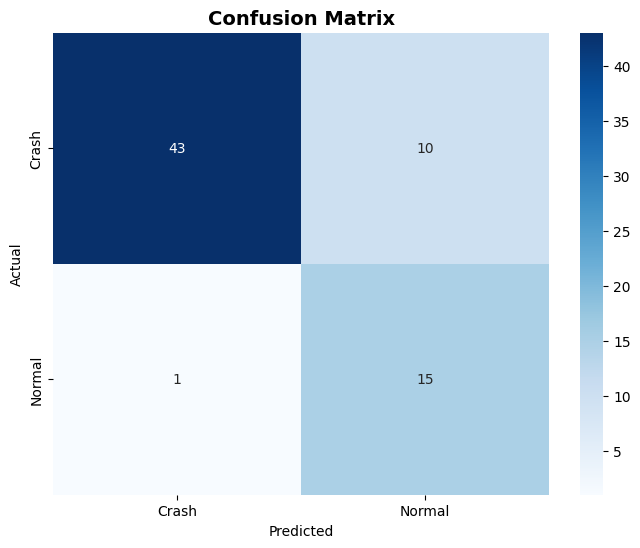

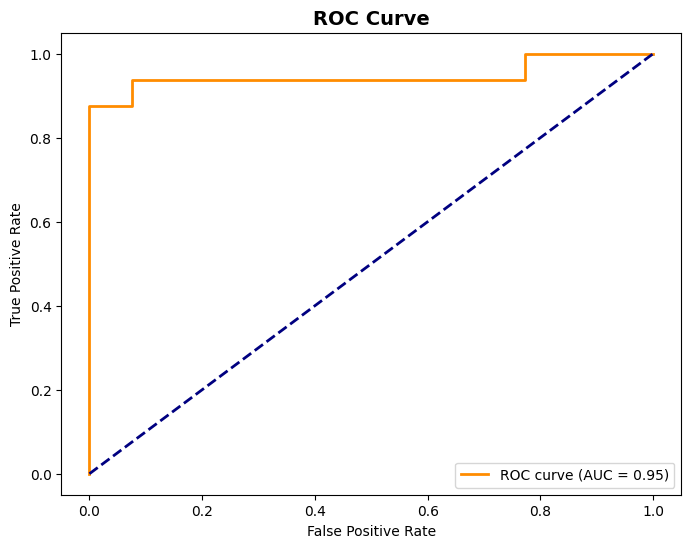

In [11]:
print("Model Evaluation")

#load best model
model = tf.keras.models.load_model('crash_model_final.h5')

#get predictions on test set
test_generator.reset()
y_pred_prob = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

#get true labels
y_true = test_generator.classes[:len(y_pred)]  # Match lengths

print(f"\nTest samples evaluated: {len(y_true)}")

#calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.2%}")

#classification report
print("\nClassification Report:")
target_names = ['Crash', 'Normal'] if test_generator.class_indices['crash'] == 0 else ['Normal', 'Crash']
print(classification_report(y_true, y_pred, target_names=target_names))

#confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

#visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:len(y_true)])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.show()

#**Training History**

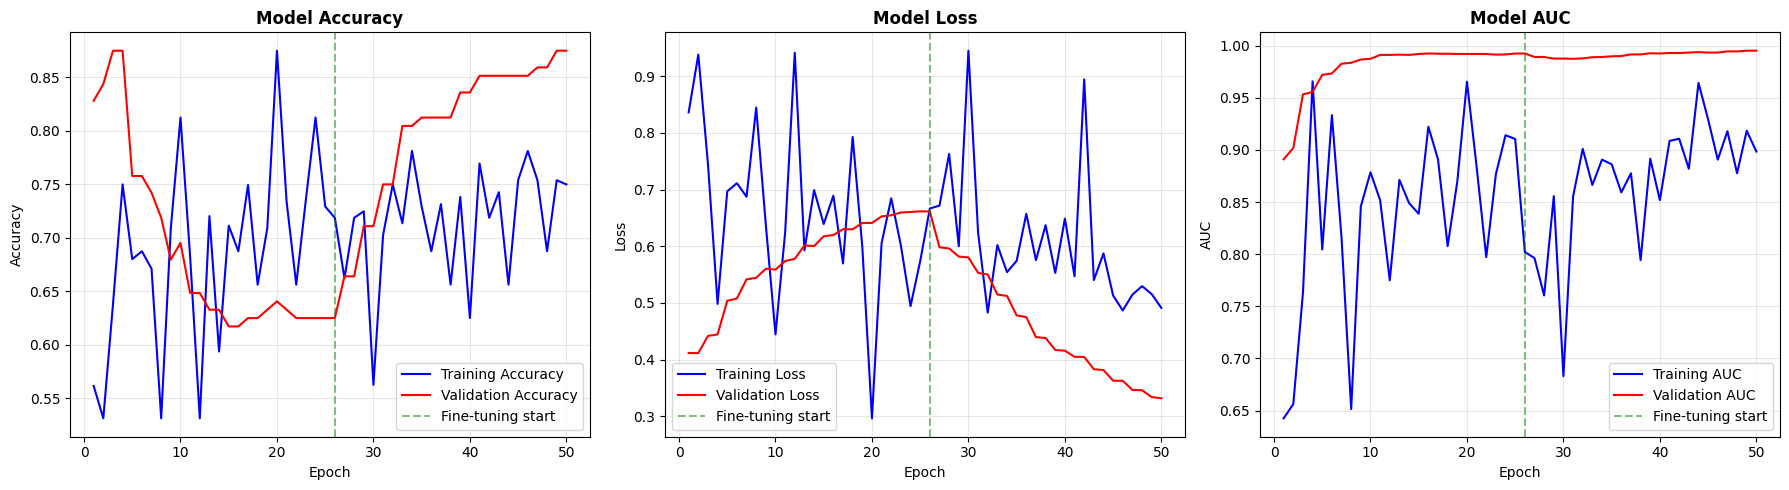

In [12]:
def plot_training(history1, history2):
    #combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    auc = history1.history['auc'] + history2.history['auc']
    val_auc = history1.history['val_auc'] + history2.history['val_auc']

    epochs = range(1, len(acc) + 1)
    phase1_epochs = len(history1.history['accuracy'])

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    #accuracy
    axes[0].plot(epochs, acc, 'b-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    axes[0].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[0].set_title('Model Accuracy', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    #loss
    axes[1].plot(epochs, loss, 'b-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'r-', label='Validation Loss')
    axes[1].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[1].set_title('Model Loss', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # AUC
    axes[2].plot(epochs, auc, 'b-', label='Training AUC')
    axes[2].plot(epochs, val_auc, 'r-', label='Validation AUC')
    axes[2].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[2].set_title('Model AUC', fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training(history1, history2)

##**Interface Functions for Future Use**

In [13]:
def predict_crash(image_path, model, threshold=0.5):
    """
    Predict crash probability for a single image
    Returns: dict with probability and class
    """
    img = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = tf.expand_dims(img_array, 0)

    prob = model.predict(img_array, verbose=0)[0][0]

    #determine class based on class_indices
    #if crash is class 0, then prob < 0.5 is crash, else normal
    #if crash is class 1, then prob > 0.5 is crash
    is_crash = prob > threshold if test_generator.class_indices['crash'] == 1 else prob < threshold

    return {
        'crash_probability': float(prob),
        'is_crash': bool(is_crash),
        'predicted_class': 'crash' if is_crash else 'normal'
    }

# Test on a sample image
test_img_path = os.path.join(BASE_PATH, 'test', 'crash', os.listdir(os.path.join(BASE_PATH, 'test', 'crash'))[0])
result = predict_crash(test_img_path, model)
print(f"\nSample Prediction:")
print(f"Image: {test_img_path}")
print(f"Result: {result}")


Sample Prediction:
Image: /content/drive/MyDrive/Colab Notebooks/TransitLK_MSFCD_CVM.v1i.folder/test/crash/frame_0295_jpg.rf.fbd1035e9ea463b90e8bfc94fb327d5d.jpg
Result: {'crash_probability': 0.23488068580627441, 'is_crash': True, 'predicted_class': 'crash'}


##**Export Model as a Keras and Converting to TensorFlow Lite Model for Mobile Usage**

In [15]:
print("Exporting Model")

#save Keras model
model.save('TransitLK_MSFCD_CVP_TF.h5')
print("Saved as TransitLK_MSFCD_CVP_TF.h5")

#convert to TnsorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('TransitLK_MSFCD_CVP_TF.tflite', 'wb') as f:
    f.write(tflite_model)
print("Saved as TransitLK_MSFCD_CVP_TF.tflite")

# Download files
files.download('TransitLK_MSFCD_CVP_TF.h5')
files.download('TransitLK_MSFCD_CVP_TF.tflite')

Exporting Model
Saved as TransitLK_MSFCD_CVP_TF.h5
Saved artifact at '/tmp/tmpk5wfb4nw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137482376199248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137482477442768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137482376188880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137482477452368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137482376185424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137482376196368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137482376185808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137482376186192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137482477442000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137482477443152: TensorSpec(shap

AttributeError: 'list' object has no attribute 'download'